In [16]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [17]:
df = pd.read_excel('/Users/albinachirkova/Desktop/per_day.xlsx')

In [18]:
df.head()

,Дата,Заражений за день,Выздоровлений за день,Смертей за день
0,2020-03-12,34,0,0
1,2020-03-13,11,0,0
2,2020-03-14,14,0,0
3,2020-03-15,4,3,0
4,2020-03-16,28,2,0


In [19]:
df['Дата'] = pd.to_datetime(df['Дата'])

In [20]:
df['Заражений за день']

0         34
1         11
2         14
3          4
4         28
        ... 
1033    2754
1034    3032
1035    4201
1036    4675
1037    5078
Name: Заражений за день, Length: 1038, dtype: int64

In [21]:
df.columns

Index(['Дата', 'Заражений за день', 'Выздоровлений за день',
       'Смертей за день'],
      dtype='object')

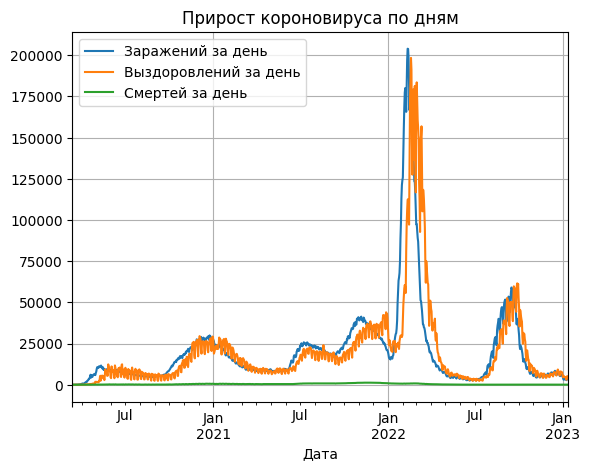

In [22]:
df.plot(x='Дата', y=['Заражений за день', 'Выздоровлений за день', 'Смертей за день'], title = 'Прирост короновируса по дням')
plt.grid()

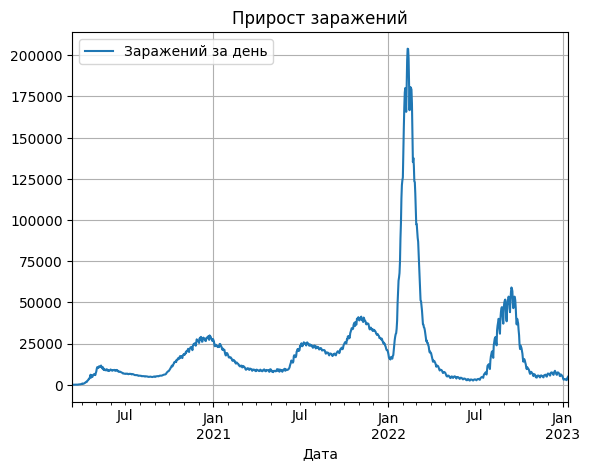

In [23]:
df.plot(x='Дата', y='Заражений за день', title = 'Прирост заражений')
plt.grid()

## Найдем частоту дискретизации 

In [24]:
t_d = np.mean(np.diff(df['Дата'])) / np.timedelta64(1, 's') #np.timedelta64(1, 's') для перевода в секунды
t_d

86400.0

In [25]:
data_sec = []
for i in range(df.shape[0]):
      data_sec.append(i*t_d)
f_d = 1/t_d
print ('Количество диапазонов с частотой дискретизации', round(f_d, 8) , 'сек -', len(data_sec))

Количество диапазонов с частотой дискретизации 1.157e-05 сек - 1038


In [26]:
df['seconds'] = data_sec

## Применим прямое Фурье преобразование для получения спектра

In [27]:
t_new = [i*t_d for i in range (int(max(data_sec)//t_d))]
df_fourier = np.fft.fft(df['Заражений за день'])
fr = [i/t_new[-1] for i in range(len(df['Заражений за день']))]

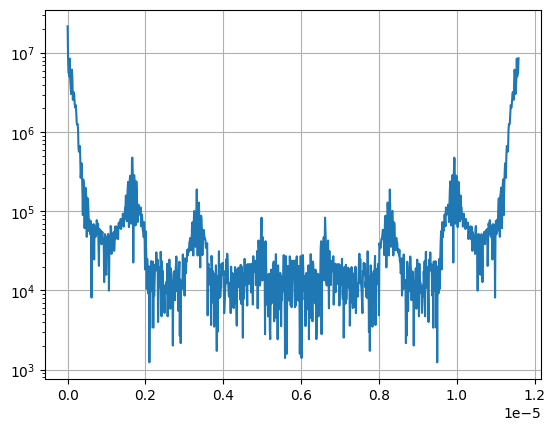

In [74]:
plt.figure()
plt.semilogy(fr, abs(df_fourier))
plt.grid()

## Выделим часть спектра

Так как спектр симетричен, то можно выделить половину

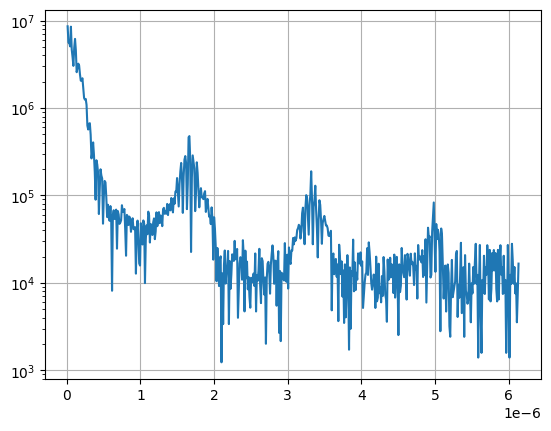

In [75]:
plt.figure()
plt.semilogy(fr[1:550], abs(df_fourier)[1:550])
plt.grid()

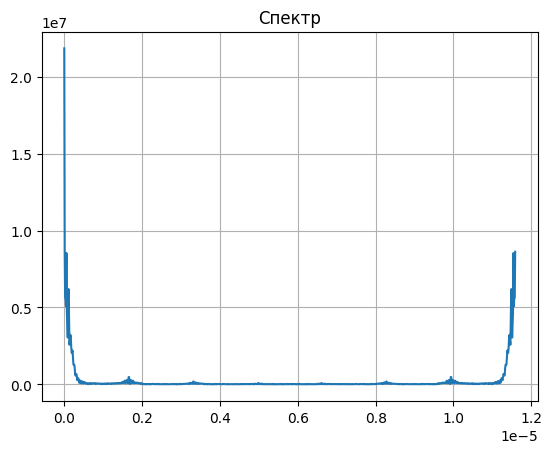

In [76]:
from scipy.signal import find_peaks
peaks = find_peaks(fr)
plt.figure()
plt.plot(fr, abs(df_fourier))
plt.title('Спектр')
plt.grid()

In [77]:
df['fourier']=abs(df_fourier)
df

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,seconds,fourier,data,local_max_fourier
0,2020-03-12,34,0,0,0.0,2.184672e+07,34,2.184672e+07
1,2020-03-13,11,0,0,86400.0,8.621454e+06,11,NaN
2,2020-03-14,14,0,0,172800.0,5.636214e+06,14,NaN
3,2020-03-15,4,3,0,259200.0,5.622244e+06,4,NaN
4,2020-03-16,28,2,0,345600.0,5.082211e+06,28,NaN
...,...,...,...,...,...,...,...,...
1033,2023-01-09,2754,2990,41,89251200.0,8.538142e+06,2754,NaN
1034,2023-01-10,3032,5062,47,89337600.0,5.082211e+06,3032,NaN
1035,2023-01-11,4201,5122,46,89424000.0,5.622244e+06,4201,NaN
1036,2023-01-12,4675,4541,48,89510400.0,5.636214e+06,4675,NaN


Покажем на графике пики на спектре

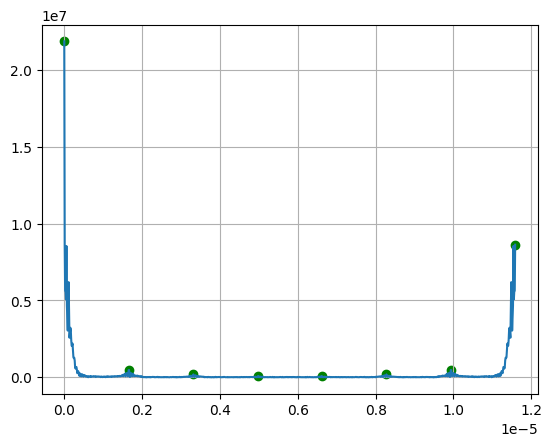

In [100]:
from scipy.signal import argrelextrema
n=50
df['local_max_fourier'] = df.iloc[argrelextrema(df.fourier.values, np.greater_equal, order=n)[0]]['fourier']
plt.plot(fr, abs(df_fourier))
plt.scatter(fr,df['local_max_fourier'] , c='g')
plt.grid()

In [129]:
df['fr']=fr
freq_of_fluc = df[abs(df_fourier)==df['local_max_fourier']].copy()
freq_of_fluc.index = np.arange(len(freq_of_fluc))
freq_of_fluc

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,seconds,fourier,data,local_max_fourier,fr
0,2020-03-12,34,0,0,0.0,2.184672e+07,34,2.184672e+07,0.000000
1,2020-08-08,5212,6615,129,12873600.0,4.781567e+05,5212,4.781567e+05,0.000002
2,2021-01-03,24150,19847,504,25660800.0,1.890479e+05,24150,1.890479e+05,0.000003
3,2021-06-01,9500,8994,372,38534400.0,8.316752e+04,9500,8.316752e+04,0.000005
4,2021-10-25,37930,20690,1069,51148800.0,8.316752e+04,37930,8.316752e+04,0.000007
5,2022-03-23,26826,70622,429,64022400.0,1.890479e+05,26826,1.890479e+05,0.000008
6,2022-08-18,35809,21491,62,76809600.0,4.781567e+05,35809,4.781567e+05,0.000010
7,2023-01-13,5078,4271,47,89596800.0,8.621454e+06,5078,8.621454e+06,0.000012


По полученной таблице можем увидеть границы периодов 

In [147]:
l = []
for i in range(0,len(freq_of_fluc)-1):
    r = freq_of_fluc.fr[i+1] - freq_of_fluc.fr[i]
    l.append(r)
l = np.array(l)
days = (1/(l*3600*24))
print(np.round(days,2))

[6.95 7.   6.95 7.1  6.95 7.   7.  ]


Периодичность примерно равна 7 дней

Найдем локальные максимумы в исходном графике

In [148]:
df ['data']=df['Заражений за день']

In [149]:
from scipy.signal import argrelextrema
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal, order=n)[0]]['data']

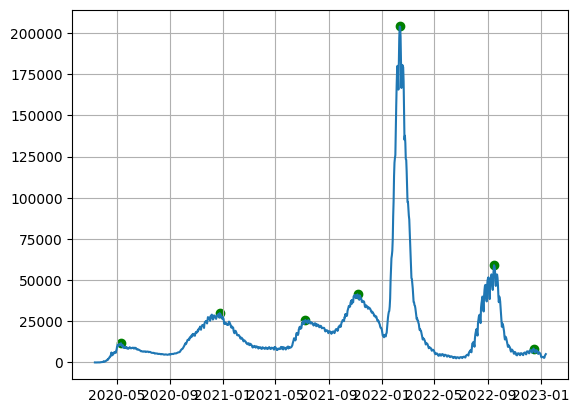

In [150]:
plt.scatter(df['Дата'], df['max'], c='g')
plt.plot(df['Дата'],df['Заражений за день'])
plt.grid()

In [151]:
df['max_NaN'] = np.where(df['max'].isnull(), 0,1)

In [152]:
print('Даты, соответствующие наивысшим точкам каждой волны заболеваемости:', '\n')
df = df[df['max_NaN']!=0]
df['Дата']

Даты, соответствующие наивысшим точкам каждой волны заболеваемости: 



60     2020-05-11
287    2020-12-24
484    2021-07-09
604    2021-11-06
701    2022-02-11
918    2022-09-16
1009   2022-12-16
Name: Дата, dtype: datetime64[ns]

## Вывод

В ходе работы было оценена высокочастотная периодичность прироста новых случаев заболевания короновирусом. Период этих изменения равен примерно 7 дней. Данные изменения могут быть связаны с увеличением заболевших после выходных. 

Были определены даты, которые соотвествуют наибольшему приросту заболеваемости в течении всего периода. В основном эти дни были осенью и зимой, когда обычно снижается иммунитет у граждан.